In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import pickle
import shap
import matplotlib.pyplot as plt

from plotnine import ggplot, aes, geom_bar, coord_flip
from plotnine import theme_minimal, scale_fill_cmap_d, theme_minimal
from plotnine import geom_label, theme, labs, theme, ggsave, element_rect, element_text

In [270]:
feat_imp_labs = {
'v2regdur'              :'Días desde\ncomienzo del régimen',
'v2regendtypems_0_lag_1':'¿El régimen terminó por\nun golpe de estado? (lag 1)*',
'v2x_hosinter'          :'¿El ejecutivo\nno es más electo?',
'v2xlg_leginter'        :'¿Legislatura\ncerrada o abortada?',
'v2regendtype_lag_1'    :'Proceso más importante\npara terminar con un\nrégimen (lag 1)',
'v2x_ex_military'       :'Influencia de las FFAA\nsobre el Poder Ejecutivo',
'v2regoppgroupsact_5'   :'¿FFA se movilizan\ncontra el régimen?',
'coup_lag_1'            :'¿golpes de estado\nen el último año?',
'v2x_ex_military_lag_1' :'Influencia de las FFAA sobre\nel Poder Ejecutivo (lag 1)',
'v2expathhs'            :'¿Cómo llega el jefe\nde estado al gob?',
'v2regendtype_lag_5'    :'¿Qué proceso fue el más importante\nen el fin del régimen? (lag 5)*',
'v2clpolcl_lag_1'       :'Libertad para todos\nlos grupos políticos',
'v2csanmvch_2_lag_10'   :'Grupos antisistema que\nmezclan métodos\nlegales e ilegales (lag 10)',
'v2juhcind'             :'Decisiones importantes\nde la Corte Suprema\nalineadas con el gobierno',
'v2exfxtmhs_lag_1'      :'Duración máxima del mandato\ndel jefe de Estado (lag 1)',
# 'v2elrgpwr_lag_5'       :'Poder relativo entre miembros electos\ny no electos a nivel regional (lag 5)',
'v2edpoledprim_lag_5'   :'¿Se enseña en la primaria contenidos\ncon valores políticos? (lag 5)',
'v2elpeace'             :'Violencia durante\nperíodo electoral',
# 'v2elrgpwr_lag_10'      :'Poder relativo entre miembros electos\ny no electos a nivel regional (lag 10)',
'v2pesecsch'            :'Porcentaje de población\nen escuela secundaria',
'v2lgqugent'            :'Cuota femenina en la cámara baja\n(o cámara única)',
'v2ellostlg'            :'Bancas obtenidas por\nel partido más grande\nen la última elección',
'v2casoe_1'             :'Emergencia nacional:\nno declarada pero medidas\npreparatorias tomadas',
'v2casoe_4'             :'Declaración de estado de\nemergencia nacional por\nconflicto armado',
'v2casoe_6'             :'Declaración de estado de\nemergencia nacional por\notros motivos',
'v2exagehos_lag_5'      :'Año de nacimiento del\njefe de estado (lag 5)',
'v2elvotbuy_lag_1'      :'¿Hubo evidencia de compra\nde votos en la última\nelección? (lag 1)',
'v2asuffrage'           :'Porcentaje de adultos con derecho\na votar mayores que la edad mínima',
'v2mecenefi_lag_1'      :'¿Busca el gobierno censurar\nla información en\ninternet? (lag 1)'
}

In [247]:
tab_feat = pd.DataFrame(feat_imp_labs,index=[0]).T.reset_index().rename(columns={'index':'Variable',0:'Descripción'})

#replace \n for ' ' in Descripción
tab_feat['Descripción'] = tab_feat['Descripción'].str.replace('\n',' ')
print(tab_feat.to_latex(escape=True,index=False))

\begin{tabular}{ll}
\toprule
Variable & Descripción \\
\midrule
v2regdur & Días desde comienzo del régimen \\
v2regendtypems\_0\_lag\_1 & ¿El régimen terminó por un golpe de estado? (lag 1)* \\
v2x\_hosinter & ¿El ejecutivo no es más electo? \\
v2xlg\_leginter & ¿Legislatura cerrada o abortada? \\
v2regendtype\_lag\_1 & Proceso más importante para terminar con un régimen (lag 1) \\
v2x\_ex\_military & Influencia de las FFAA sobre el Poder Ejecutivo \\
v2regoppgroupsact\_5 & ¿FFA se movilizan contra el régimen? \\
coup\_lag\_1 & ¿golpes de estado en el último año? \\
v2x\_ex\_military\_lag\_1 & Influencia de las FFAA sobre el Poder Ejecutivo (lag 1) \\
v2expathhs & ¿Cómo llega el jefe de estado al gob? \\
v2regendtype\_lag\_5 & ¿Qué proceso fue el más importante en el fin del régimen? (lag 5)* \\
v2clpolcl\_lag\_1 & Libertad para todos los grupos sociales \\
v2csanmvch\_2\_lag\_10 & Grupos antisistema que mezclan métodos legales e ilegales (lag 10) \\
v2juhcind & Decisiones importantes 

In [2]:
def get_data():
    # se toma archivo pickle, si no existe se crea desde el csv generado en el script de R
    df = pd.read_csv('../data/vdem_coup_ML.csv')
    df = df[df['year']>=1970]
    # drop non numeric columns for df pandas dataframe
    df = df.select_dtypes(include=['number'])
    df = df[df.columns[~df.columns.str.startswith('e_')]]

    # divido en X e y
    X = df.drop(columns='coup')
    y = df.set_index('year')['coup']
    return X, y, df


In [3]:
X,y, df = get_data()

In [4]:
def score(modelo,anio1):
    dic = {}
    
    # se toma información del modelo desde el config file
    if modelo=='XGB':
        output = 'modelos/'+str(anio1)+'/xgboost.pkl'
    else:
        output = 'modelos/'+str(anio1)+'/random_forest.pkl'

    # cargamos modelo ya entrenado
    with open(output, 'rb') as f:
        clf = pickle.load(f)

    anios = range(anio1,2024)
    
    dic['AUC'] = pd.DataFrame(index=anios)

    for anio2 in anios:
        X_test, y_test           = X[X['year'] == anio2], y[y.index == anio2]
        X_test_acum, y_test_acum = X[X['year'].between(anio1,anio2)], y[(y.index>=anio1) & (y.index<=anio2)]
        
        y_pred = clf.predict(X_test)
                    
        y_pred_acum = clf.predict(X_test_acum)
        
        dic['AUC'].loc[anio2,'AUC'] = roc_auc_score(y_test, y_pred)
        dic['AUC'].loc[anio2,'AUC acumulada'] = roc_auc_score(y_test_acum, y_pred_acum)
    
    return dic

In [5]:
modelos = {}
for anio in range(2020,2024):
    modelos[anio] = {}
    modelos[anio]['RF'] = score('RF',anio)
    modelos[anio]['XGB'] = score('XGB',anio)

In [6]:
def reporte(anio):
    return    pd.concat((modelos[anio]['XGB']['AUC'],
                         modelos[anio]['RF']['AUC']),
                        axis=1,keys=['XGBoost','Random Forest'])

In [14]:
reporte(2020)

XGBoost               Random Forest              
           AUC AUC acumulada           AUC AUC acumulada
2020  1.000000      1.000000      1.000000      1.000000
2021  0.750000      0.785714      0.747110      0.784290
2022  0.666667      0.750000      0.666667      0.749051
2023  0.666667      0.730769      0.666667      0.730058

In [8]:
pd.concat((reporte(2021), reporte(2022), reporte(2023)),axis=0)

XGBoost               Random Forest              
           AUC AUC acumulada           AUC AUC acumulada
2021  0.750000      0.750000      0.747110      0.747110
2022  0.666667      0.722222      0.666667      0.720790
2023  0.666667      0.708333      0.833333      0.749048
2022  0.666667      0.666667      0.666667      0.666667
2023  0.663826      0.665246      0.833333      0.750000
2023  0.663826      0.663826      0.833333      0.833333

# Análisis individual de modelo

In [4]:
with open('modelos/2020/random_forest.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('modelos/2020/xgboost.pkl', 'rb') as f:
    xgb = pickle.load(f)

In [5]:
import json
with open('../data/country_codes.json',encoding='utf-8') as f:
    country_codes = json.load(f)

In [6]:
# X,y, df = get_data()

X_test  = X[X['year'].between(2020,2022)]
y_test  = y[(y.index>=2020) & (y.index<=2022)]
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

## Matriz de confusión

In [7]:
resultados = df.loc[df['year'].between(2020,2022),['country_id','year','coup']]

resultados['random forest'] = y_pred_rf
resultados['xgboost']    = y_pred_xgb

resultados['country_name'] = resultados['country_id'].astype(str).map(country_codes)


# replace coup and coup_pred with 'si' and 'no'
resultados['coup'] = resultados['coup'].replace({1:'Sí',0:'No'})
resultados['random forest'] = resultados['random forest'].replace({1:'Sí',0:'No'})
resultados['xgboost'] = resultados['xgboost'].replace({1:'Sí',0:'No'})

resultados.loc[(resultados['random forest']=='Sí')&(resultados['coup']=='Sí'),'random forest'] = 'Verdadero positivo'
resultados.loc[(resultados['random forest']=='Sí')&(resultados['coup']=='No'),'random forest'] = 'Falso positivo'
resultados.loc[(resultados['random forest']=='No')&(resultados['coup']=='No'),'random forest'] = 'Verdadero negativo'
resultados.loc[(resultados['random forest']=='No')&(resultados['coup']=='Sí'),'random forest'] = 'Falso negativo'

resultados.loc[(resultados['xgboost']=='Sí')&(resultados['coup']=='Sí'),'xgboost'] = 'Verdadero positivo'
resultados.loc[(resultados['xgboost']=='Sí')&(resultados['coup']=='No'),'xgboost'] = 'Falso positivo'
resultados.loc[(resultados['xgboost']=='No')&(resultados['coup']=='No'),'xgboost'] = 'Verdadero negativo'
resultados.loc[(resultados['xgboost']=='No')&(resultados['coup']=='Sí'),'xgboost'] = 'Falso negativo'

TP_RF = (resultados['random forest'] == 'Verdadero positivo')
TP_XGB = (resultados['xgboost'] == 'Verdadero positivo')
FP_RF = (resultados['random forest'] == 'Falso positivo')
FP_XGB = (resultados['xgboost'] == 'Falso positivo')
TN_RF = (resultados['random forest'] == 'Verdadero negativo')
TN_XGB = (resultados['xgboost'] == 'Verdadero negativo')
FN_RF = (resultados['random forest'] == 'Falso negativo')
FN_XGB = (resultados['xgboost'] == 'Falso negativo')

In [8]:
resultados

,country_id,year,coup,random forest,xgboost,country_name
70,3,2020,No,Verdadero negativo,Verdadero negativo,México
71,3,2021,No,Verdadero negativo,Verdadero negativo,México
72,3,2022,No,Verdadero negativo,Verdadero negativo,México
144,4,2020,No,Verdadero negativo,Verdadero negativo,Surinam
145,4,2021,No,Verdadero negativo,Verdadero negativo,Surinam
...,...,...,...,...,...,...
12211,210,2021,No,Verdadero negativo,Verdadero negativo,Hungría
12212,210,2022,No,Verdadero negativo,Verdadero negativo,Hungría
12284,236,2020,No,Verdadero negativo,Verdadero negativo,Zanzíbar
12285,236,2021,No,Verdadero negativo,Verdadero negativo,Zanzíbar


In [9]:
resultados.loc[TP_RF|TP_XGB|FP_RF|FP_XGB|FN_RF|FN_XGB,['country_name','year','coup','random forest','xgboost']]\
    .sort_values(['year'])\
    .rename(columns={'country_name':'país','year':'año','coup':'¿Hubo golpe?','random forest':'Random Forest','xgboost':'xgboost'})


,país,año,¿Hubo golpe?,Random Forest,xgboost
1718,Malí,2020,Sí,Verdadero positivo,Verdadero positivo
589,Birmania/Myanmar,2021,Sí,Verdadero positivo,Verdadero positivo
1719,Malí,2021,Sí,Falso negativo,Falso negativo
2028,Sudán,2021,Sí,Verdadero positivo,Verdadero positivo
2202,Afganistán,2021,No,Falso positivo,Verdadero negativo
3929,Níger,2021,Sí,Falso negativo,Falso negativo
4151,Guinea,2021,Sí,Verdadero positivo,Verdadero positivo
7344,Chad,2021,Sí,Falso negativo,Falso negativo
3486,Burkina Faso,2022,Sí,Verdadero positivo,Verdadero positivo
8045,Guinea-Bisáu,2022,Sí,Falso negativo,Falso negativo


## Probabilidades

In [271]:
def prob_plot(model):
    resultados['coup_prob'] = model.predict_proba(X_test)[:,1]
    proba = resultados[['country_name','year','coup_prob','coup']].rename(columns={'coup':'golpe'})
    proba['pais_año'] = proba['country_name'] + ' ' + proba['year'].astype(str)
    # resultados.loc[resultados['coup']=='No','pais_año'] = ''
    proba = proba.sort_values('coup_prob',ascending=False).head(25)
    # resultados.rename({'coup':'¿'})
    f = ggplot(proba)+aes(x='reorder(pais_año,coup_prob)',y='coup_prob',fill='golpe')+\
        geom_bar(stat='identity')+coord_flip()+\
        labs(x='',y='Probabilidad de golpe de estado')+\
        theme_minimal()+\
        theme(plot_background=element_rect(color='black'),
            plot_caption=element_text(size=7,alpha=.7))
    return f

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/6_prob_xgb.png


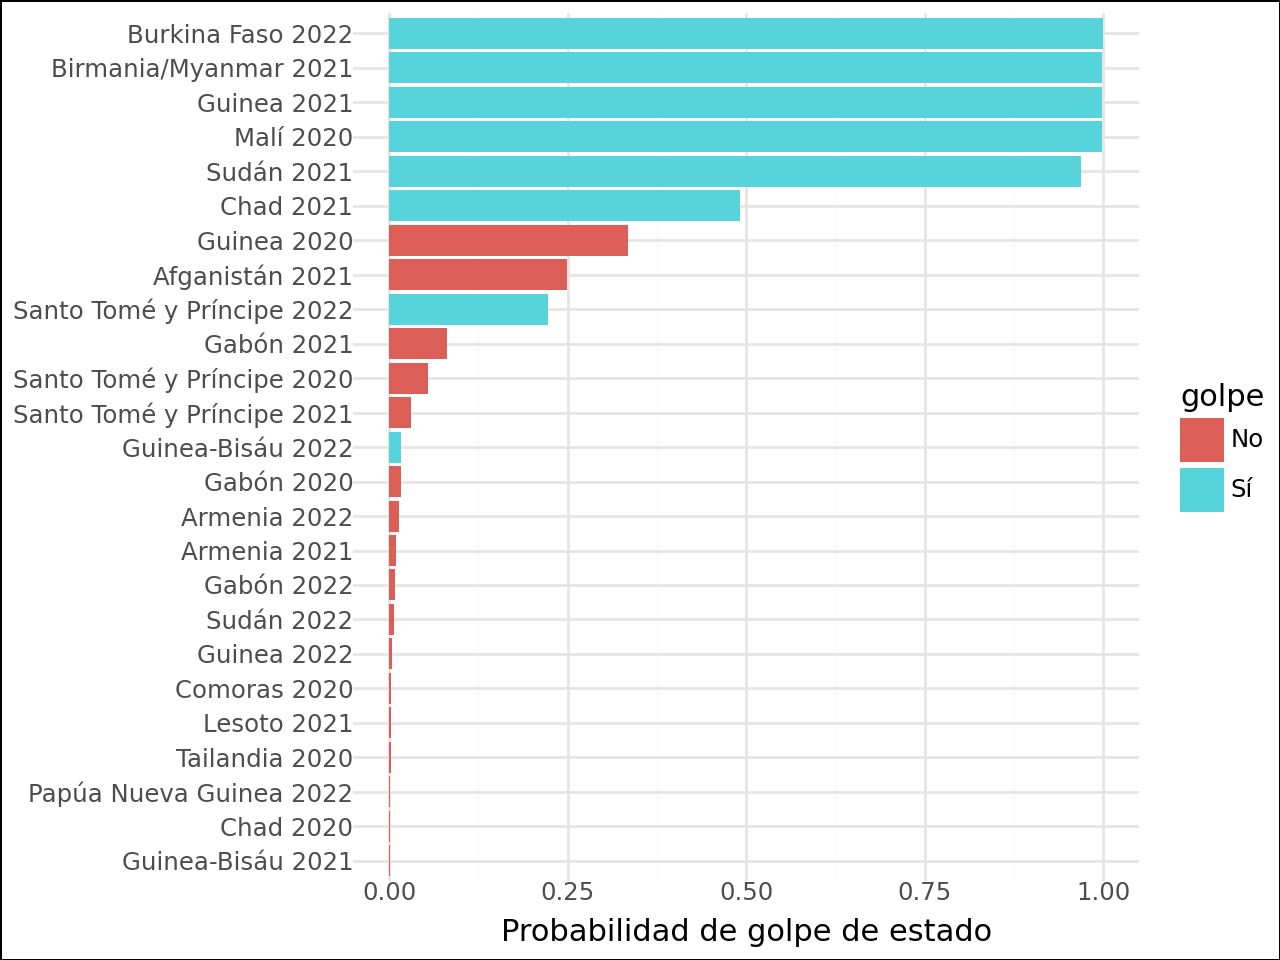

In [366]:
prob_xgb = prob_plot(xgb)
ggsave(prob_xgb,'../entregas/imagenes/6_prob_xgb.png',width=10,height=5)
prob_xgb

In [367]:
check = resultados.copy()
check['coup_prob_rf'] = rf.predict_proba(X_test)[:,1]
check['coup_prob_xgb'] = xgb.predict_proba(X_test)[:,1]

In [368]:
check = check.sort_values('coup_prob_rf',ascending=False).reset_index(drop=True)
check['top_rf'] = check.index+1
check = check.sort_values('coup_prob_xgb',ascending=False).reset_index(drop=True)
check['top_xgb'] = check.index+1

In [370]:
check[(check['country_name']=='Níger')&(check['year']==2021)].T

,43
country_id,60
year,2021
coup,Sí
random forest,Falso negativo
xgboost,Falso negativo
country_name,Níger
coup_prob,0.00033
coup_prob_rf,0.0446
coup_prob_xgb,0.00033
top_rf,36


c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/5_prob_rf.png


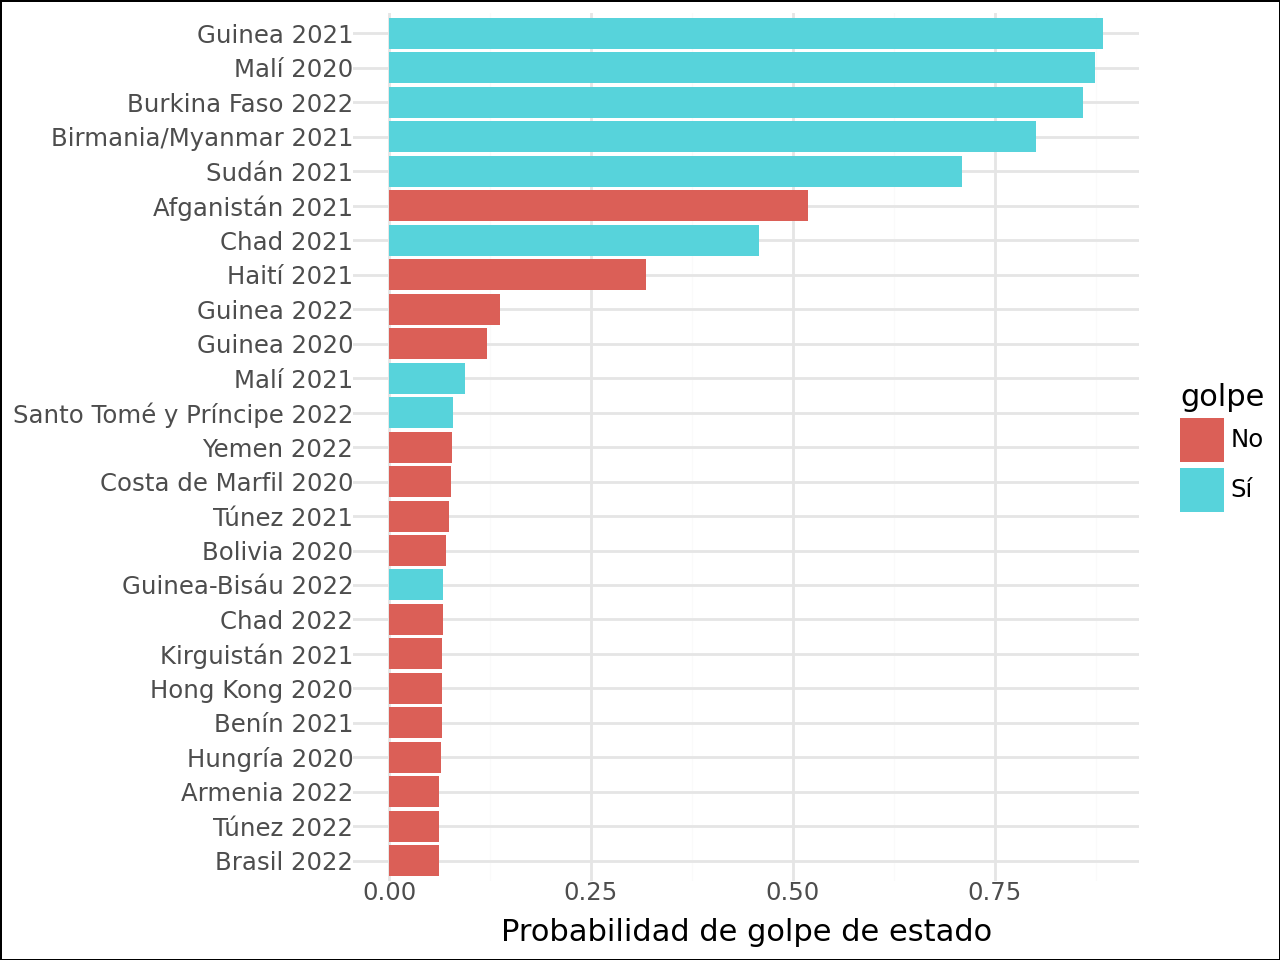

In [371]:
prob_rf = prob_plot(rf)
ggsave(prob_rf,'../entregas/imagenes/5_prob_rf.png',width=10,height=5)
prob_rf

## Importancia de variable

In [238]:
anexo_val = pd.DataFrame(feat_imp_labs.values(),feat_imp_labs.keys())
anexo_val[0] = anexo_val[0].str.replace('\n',' ')
print(anexo_val.to_latex(escape=True))

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
v2regdur & Días desde comienzo del régimen \\
v2regendtypems\_0\_lag\_1 & ¿El régimen terminó por un golpe de estado? (lag 1)* \\
v2x\_hosinter & ¿El ejecutivo no es más electo? \\
v2xlg\_leginter & ¿Legislatura cerrada o abortada? \\
v2regendtype\_lag\_1 & Proceso más importante para terminar con un régimen (lag 1) \\
v2x\_ex\_military & Influencia de las FFAA sobre el Poder Ejecutivo \\
v2regoppgroupsact\_5 & FFA se movilizan contra el régimen? \\
coup\_lag\_1 & ¿golpes de estado en el último año? \\
v2x\_ex\_military\_lag\_1 & Influencia de las FFAA sobre el Poder Ejecutivo (lag 1) \\
v2expathhs & ¿Cómo llega el jefe de estado al gob? \\
v2regendtype\_lag\_5 & ¿Qué proceso fue el más importante en el fin del régimen? (lag 5)* \\
v2clpolcl\_lag\_1 & Libertad para todos los grupos sociales \\
v2csanmvch\_2\_lag\_10 & Grupos antisistema que mezclan métodos legales e ilegales (lag 10) \\
v2juhcind & Decisiones importantes de la Corte Suprema

In [272]:
def feature_imp(model,caption):

    # create a dataframe with feature importances and column name
    feat_imp = pd.DataFrame(zip(X.columns,model.feature_importances_), columns=['Variable','Importancia'])
    feat_imp.sort_values('Importancia',ascending=False,inplace=True)

    # feat_imp['Importancia acumulada'] = np.cumsum(feat_imp['Importancia'])
    # feat_imp = pd.merge(feat_imp,codebook_tag,how='left')

    tab_feat_imp = feat_imp[['Variable','Importancia']].sort_values('Importancia',ascending=False).drop_duplicates().head(7).reset_index(drop=True)
    tab_feat_imp['Importancia'] = tab_feat_imp['Importancia'].astype(float)
    tab_feat_imp['Variable ext'] = tab_feat_imp['Variable'].apply(lambda x: feat_imp_labs[x] if x in feat_imp_labs.keys() else x)
    tab_feat_imp.sort_values(by='Importancia',ascending=False).reset_index(drop = True)
    #para ordenar barras
    tab_feat_imp['Variable ext'] = pd.Categorical(tab_feat_imp['Variable ext'],categories=pd.unique(tab_feat_imp['Variable ext']))
    # tab_feat_imp['Importancia'] = tab_feat_imp['Importancia'].round(3)
    f = ggplot(tab_feat_imp)\
        + aes(x="Variable ext", y="Importancia")\
        + geom_bar(stat="identity",fill='#377eb8') + coord_flip()\
        + geom_label(aes(label='round(Importancia,3)'),size=7)\
        + scale_fill_cmap_d(cmap_name='viridis')\
        + labs(x='',y='Importancia de la variable',
            caption=caption)\
        + theme_minimal()\
        +theme(legend_position='none',plot_background=element_rect(color='black'),
            plot_caption=element_text(size=7,alpha=.7))
    return f


In [391]:
pd.DataFrame(zip(xgb.feature_importances_,X.columns)).sort_values(0,ascending=False).head(7)[0].sum()

0.13234453

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/7_feature_importance_rf.png


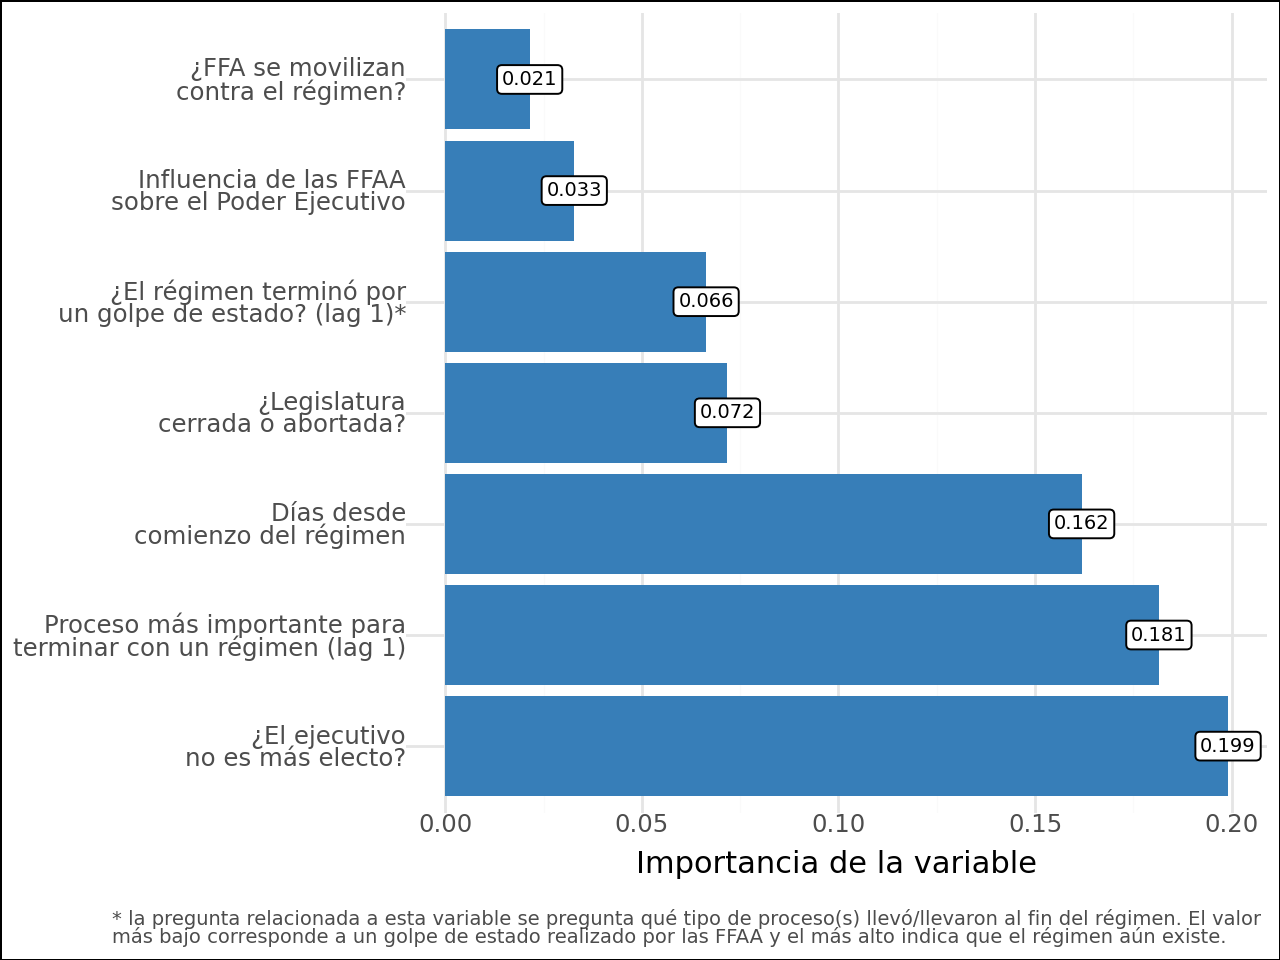

In [20]:
feat_imp_rf = feature_imp(rf,'''
    * la pregunta relacionada a esta variable se pregunta qué tipo de proceso(s) llevó/llevaron al fin del régimen. El valor 
    más bajo corresponde a un golpe de estado realizado por las FFAA y el más alto indica que el régimen aún existe.''')
ggsave(feat_imp_rf,'../entregas/imagenes/7_feature_importance_rf.png',width=6,height=4)
feat_imp_rf

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/8_feature_importance_xgb.png


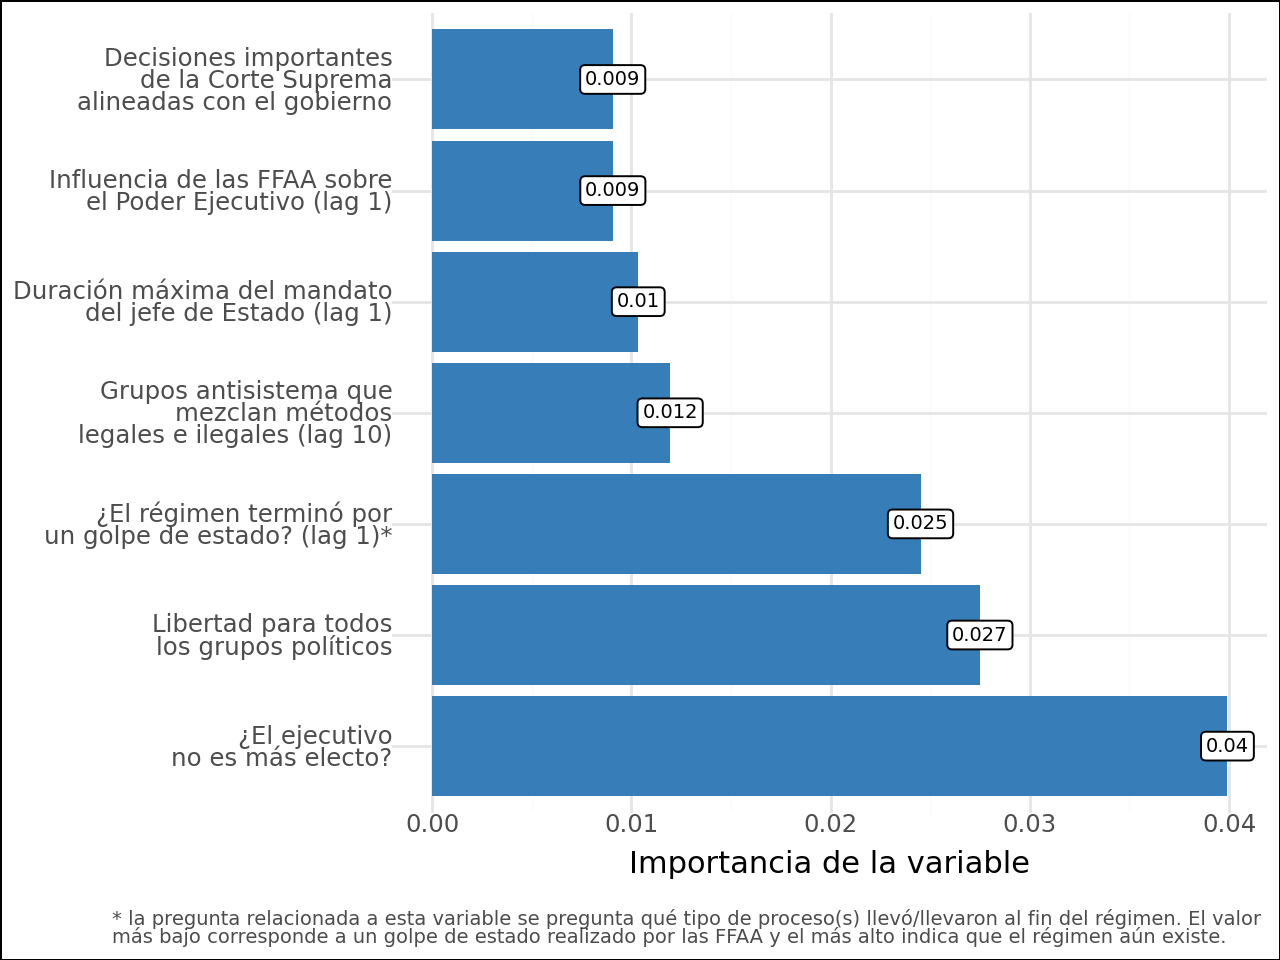

In [273]:

feat_imp_xgb = feature_imp(xgb,'''
    * la pregunta relacionada a esta variable se pregunta qué tipo de proceso(s) llevó/llevaron al fin del régimen. El valor 
    más bajo corresponde a un golpe de estado realizado por las FFAA y el más alto indica que el régimen aún existe.''')
ggsave(feat_imp_xgb,'../entregas/imagenes/8_feature_importance_xgb.png',width=6,height=4)
feat_imp_xgb

# Shapley values

In [267]:
def shapley_violin_plot(model,X,country:bool=False,annotations:list=None):

    shap_values = shap.TreeExplainer(model).shap_values(X)

    X_imp_labs = X.columns.map(lambda x: feat_imp_labs[x] if x in feat_imp_labs.keys() else x)
    # Obtener la figura actual
    fig = plt.figure()
    # detect if model is a random forest
    if not hasattr(model,'booster'):       
        shap_values = shap_values[:,:,1]
        nombre = 'Random Forest'
    else:
        nombre = 'XGBoost'

    if not country:
        #use viridids color palette
        shap.violin_plot(shap_values, X,max_display=11,
                        feature_names=X_imp_labs,
                        plot_size=.7,show=False,
                        color_bar_label='Valor de la variable'
                        )
        
    else:
        # Crear el gráfico SHAP summary
        shap.summary_plot(shap_values, X, max_display=4, show=False,
                        feature_names=X_imp_labs, plot_size=.6,
                        color_bar_label='Valor de la variable')

    # Agregar las anotaciones
    if annotations:
        for annotation in annotations:
            plt.annotate(
                annotation.get('text'),
                xy=annotation.get('xy'),
                xytext=annotation.get('xytext', annotation.get('xy')),
                # arrowprops=annotation.get('arrowprops', {})
            )
        
        
    plt.xlabel(f'Valor Shapley (Impacto en la salida del modelo {nombre})')

    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(2)
    
    return fig

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


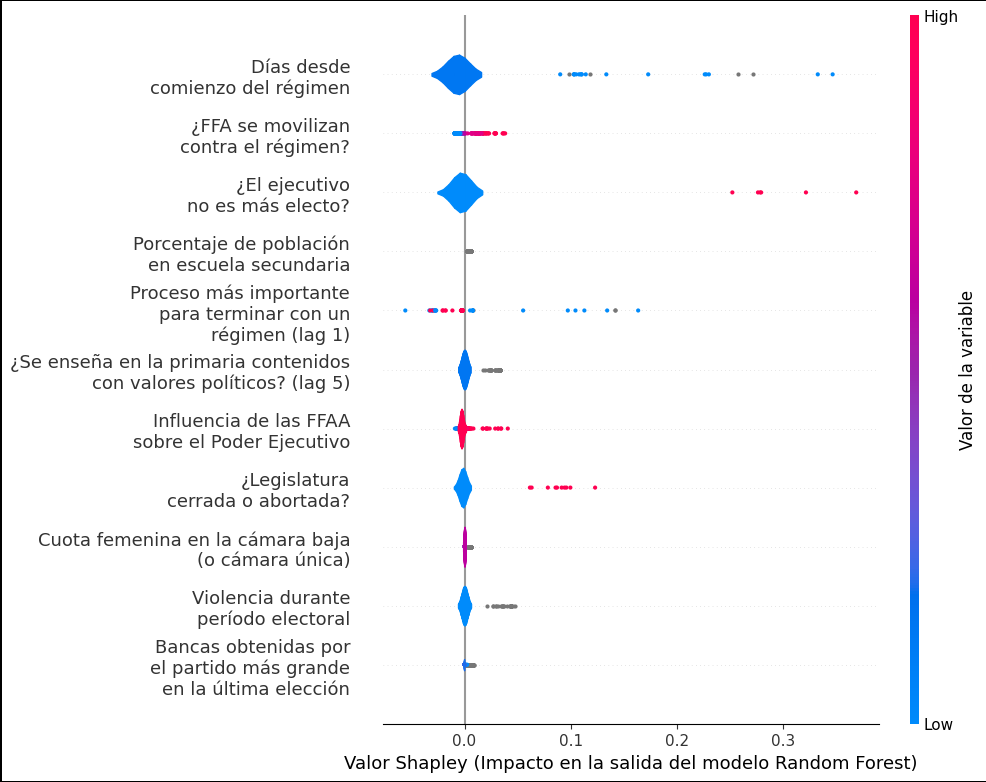

In [268]:
f = shapley_violin_plot(rf,X_test)
plt.savefig('../entregas/imagenes/9_shapley_values_rf.png',bbox_inches='tight',dpi=300)

In [240]:
def get_shap_outliers(model,X,feat):
    X_test_bk = X_test.copy()
    X_test_bk['country_name'] = X_test_bk['country_id'].astype(str).map(country_codes)
    X_test_bk.reset_index(drop=True,inplace=True)

    
    shp = shap.TreeExplainer(model).shap_values(X_test)
    if not hasattr(model,'booster'):
        shp = shp[:,:,1]
        modelo = 'random forest'
    else:
        modelo = 'xgboost'
    
    shap_values = pd.DataFrame(shp,columns=X_test.columns)\
        .rename(columns={feat:feat+'_shap'})
    print(feat_imp_labs[feat])
    df_final =  pd.concat((X_test_bk[['country_name','year',feat]],shap_values[feat+'_shap']),axis=1)\
        .sort_values(feat+'_shap',ascending=False).reset_index(drop=True)
        
    df_final = pd.merge(df_final,resultados[['country_name','year','coup',modelo]])
    
    df_final = pd.merge(df_final,pd.DataFrame(
    {'country_name': ['Malí','Birmania/Myanmar','Malí','Sudán','Afganistán','Níger','Guinea','Chad','Burkina Faso','Guinea-Bisáu','Santo Tomé y Príncipe'],
    'year': [2020,2021,2021,2021,2021,2021,2021,2021,2022,2022,2022],
    # 'coup':[1,1,1,1,0,1,1,1,1,1,1],
    'exitoso': ['Sí','Sí','Sí','Sí','-','No','Sí','No','Sí','No','No']}
    ))
        
    mali_2020 = (df_final['year']==2020)&(df_final['country_name']=='Malí')
    myanmar_2021 = (df_final['year']==2021)&(df_final['country_name']=='Birmania/Myanmar')
    mali_2021 = (df_final['year']==2021)&(df_final['country_name']=='Malí')
    sudan_2021 = (df_final['year']==2021)&(df_final['country_name']=='Sudán')
    afg_2021 = (df_final['year']==2021)&(df_final['country_name']=='Afganistán')
    niger_2021 = (df_final['year']==2021)&(df_final['country_name']=='Níger')
    guinea_2021 = (df_final['year']==2021)&(df_final['country_name']=='Guinea')
    chad_2021 = (df_final['year']==2021)&(df_final['country_name']=='Chad')
    burkina_faso_2022 = (df_final['year']==2022)&(df_final['country_name']=='Burkina Faso')
    guin_bis_2022 = (df_final['year']==2022)&(df_final['country_name']=='Guinea-Bisáu')
    santo_tom_2022 = (df_final['year']==2022)&(df_final['country_name']=='Santo Tomé y Príncipe')
    
    
    
    return df_final[mali_2020|myanmar_2021|mali_2021|sudan_2021|afg_2021|niger_2021|guinea_2021|chad_2021|burkina_faso_2022|guin_bis_2022|santo_tom_2022]\
        .rename(columns={'coup':'golpe','year':'año','country_name':'país',feat+'_shap':'shap'})

In [293]:
shp_rf_regdur = get_shap_outliers(rf,X_test,'v2regdur')
shp_rf_regdur['v2regdur'] = shp_rf_regdur['v2regdur'].astype(int)
shp_rf_regdur
# print(shp_rf_regdur.to_latex(index=False,escape=True,float_format="%.3f"))

Días desde
comienzo del régimen


,país,año,v2regdur,shap,golpe,random forest,exitoso
0,Sudán,2021,0,0.346341,Sí,Verdadero positivo,Sí
1,Birmania/Myanmar,2021,0,0.332357,Sí,Verdadero positivo,Sí
2,Guinea,2021,0,0.229890,Sí,Verdadero positivo,Sí
3,Burkina Faso,2022,0,0.227329,Sí,Verdadero positivo,Sí
4,Malí,2020,0,0.226010,Sí,Verdadero positivo,Sí
5,Afganistán,2021,0,0.172800,No,Falso positivo,-
6,Chad,2021,0,0.090021,Sí,Falso negativo,No
7,Santo Tomé y Príncipe,2022,11230,-0.005706,Sí,Falso negativo,No
8,Níger,2021,3556,-0.006590,Sí,Falso negativo,No
9,Guinea-Bisáu,2022,2749,-0.007456,Sí,Falso negativo,No


In [291]:
shp_ref_hosinter = get_shap_outliers(rf,X_test,'v2x_hosinter')
shp_ref_hosinter['v2x_hosinter'] = shp_ref_hosinter['v2x_hosinter'].astype(int)
shp_ref_hosinter
# print(shp_ref_hosinter.to_latex(index=False,escape=True,float_format="%.3f"))

¿El ejecutivo
no es más electo?


,país,año,v2x_hosinter,shap,golpe,random forest,exitoso
0,Chad,2021,1,0.321217,Sí,Falso negativo,No
1,Guinea,2021,1,0.279093,Sí,Verdadero positivo,Sí
2,Burkina Faso,2022,1,0.278141,Sí,Verdadero positivo,Sí
3,Malí,2020,1,0.276087,Sí,Verdadero positivo,Sí
4,Afganistán,2021,1,0.251989,No,Falso positivo,-
5,Birmania/Myanmar,2021,0,-0.002388,Sí,Verdadero positivo,Sí
6,Sudán,2021,0,-0.002437,Sí,Verdadero positivo,Sí
7,Santo Tomé y Príncipe,2022,0,-0.003052,Sí,Falso negativo,No
8,Malí,2021,0,-0.003141,Sí,Falso negativo,Sí
9,Níger,2021,0,-0.003198,Sí,Falso negativo,No


In [292]:
shp_rf_regendtype = get_shap_outliers(rf,X_test,'v2regendtype_lag_1')
shp_rf_regendtype['v2regendtype_lag_1'] = shp_rf_regendtype['v2regendtype_lag_1'].astype(int)
# print(shp_rf_regendtype.to_latex(index=False,escape=True,float_format="%.3f"))
shp_rf_regendtype

Proceso más importante para
terminar con un régimen (lag 1)


,país,año,v2regendtype_lag_1,shap,golpe,random forest,exitoso
0,Birmania/Myanmar,2021,0,0.163360,Sí,Verdadero positivo,Sí
1,Sudán,2021,0,0.134201,Sí,Verdadero positivo,Sí
2,Guinea,2021,0,0.112750,Sí,Verdadero positivo,Sí
3,Malí,2020,0,0.104370,Sí,Verdadero positivo,Sí
4,Burkina Faso,2022,0,0.097168,Sí,Verdadero positivo,Sí
5,Afganistán,2021,1,0.055126,No,Falso positivo,-
6,Santo Tomé y Príncipe,2022,13,-0.002172,Sí,Falso negativo,No
7,Níger,2021,13,-0.002252,Sí,Falso negativo,No
8,Malí,2021,13,-0.003219,Sí,Falso negativo,Sí
9,Guinea-Bisáu,2022,13,-0.020695,Sí,Falso negativo,No


In [251]:
shp_rf_leginter = get_shap_outliers(rf,X_test,'v2xlg_leginter')
# print(shp_rf_leginter.to_latex(index=False,escape=True,float_format="%.3f"))
shp_rf_leginter

¿Legislatura
cerrada o abortada?


,país,año,v2xlg_leginter,shap,golpe,random forest,exitoso
0,Birmania/Myanmar,2021,1,0.122849,Sí,Verdadero positivo,Sí
1,Guinea,2021,1,0.095797,Sí,Verdadero positivo,Sí
2,Burkina Faso,2022,1,0.094042,Sí,Verdadero positivo,Sí
3,Malí,2020,1,0.091372,Sí,Verdadero positivo,Sí
4,Guinea-Bisáu,2022,1,0.085627,Sí,Falso negativo,No
5,Chad,2021,1,0.063124,Sí,Falso negativo,No
6,Afganistán,2021,1,0.061502,No,Falso positivo,-
7,Santo Tomé y Príncipe,2022,0,-0.001443,Sí,Falso negativo,No
8,Níger,2021,0,-0.001480,Sí,Falso negativo,No
9,Malí,2021,0,-0.002194,Sí,Falso negativo,Sí


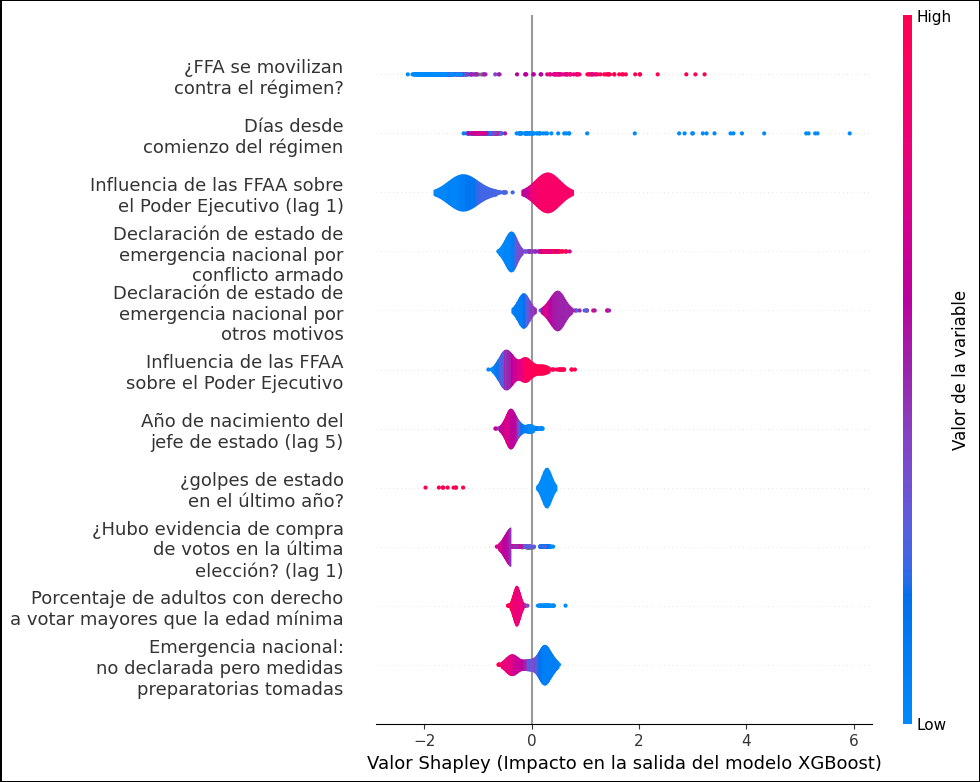

In [269]:
f = shapley_violin_plot(xgb,X_test)
plt.savefig('../entregas/imagenes/10_shapley_values_xgb.png',bbox_inches='tight',dpi=300)

In [260]:
shp_xgb_regdur = get_shap_outliers(xgb,X_test,'v2regdur')
shp_xgb_regdur['v2regdur'] = shp_xgb_regdur['v2regdur'].astype(int)
shp_xgb_regdur
# print('\\begin{table}[H]\n\\centering\n',shp_xgb_regdur.to_latex(index=False,escape=True,float_format="%.3f"))

Días desde
comienzo del régimen


,país,año,v2regdur,shap,golpe,xgboost,exitoso
0,Birmania/Myanmar,2021,0,5.927027,Sí,Verdadero positivo,Sí
1,Sudán,2021,0,5.327822,Sí,Verdadero positivo,Sí
2,Malí,2020,0,5.283136,Sí,Verdadero positivo,Sí
3,Burkina Faso,2022,0,5.159431,Sí,Verdadero positivo,Sí
4,Guinea,2021,0,5.115465,Sí,Verdadero positivo,Sí
5,Afganistán,2021,0,4.333076,No,Verdadero negativo,-
6,Chad,2021,0,2.746758,Sí,Falso negativo,No
7,Malí,2021,136,1.033504,Sí,Falso negativo,Sí
8,Santo Tomé y Príncipe,2022,11230,-0.671448,Sí,Falso negativo,No
9,Níger,2021,3556,-0.845186,Sí,Falso negativo,No


In [258]:
get_shap_outliers(xgb,X_test,'v2regoppgroupsact_5')

¿FFA se movilizan
contra el régimen?


,país,año,v2regoppgroupsact_5,shap,golpe,xgboost,exitoso
0,Santo Tomé y Príncipe,2022,0.500,3.221869,Sí,Falso negativo,No
1,Níger,2021,0.429,2.019907,Sí,Falso negativo,No
2,Malí,2020,0.686,2.010915,Sí,Verdadero positivo,Sí
3,Malí,2021,0.400,1.681705,Sí,Falso negativo,Sí
4,Guinea-Bisáu,2022,0.250,1.190970,Sí,Falso negativo,No
5,Sudán,2021,0.333,0.862872,Sí,Verdadero positivo,Sí
6,Chad,2021,0.325,0.711348,Sí,Falso negativo,No
7,Birmania/Myanmar,2021,0.271,0.493683,Sí,Verdadero positivo,Sí
8,Burkina Faso,2022,0.250,0.468432,Sí,Verdadero positivo,Sí
9,Guinea,2021,0.081,-1.071697,Sí,Verdadero positivo,Sí


In [259]:
get_shap_outliers(xgb,X_test,'v2x_ex_military')

Influencia de las FFAA
sobre el Poder Ejecutivo


,país,año,v2x_ex_military,shap,golpe,xgboost,exitoso
0,Guinea,2021,1.000,0.803963,Sí,Verdadero positivo,Sí
1,Burkina Faso,2022,0.938,0.743696,Sí,Verdadero positivo,Sí
2,Malí,2020,0.917,0.580317,Sí,Verdadero positivo,Sí
3,Malí,2021,1.000,0.553643,Sí,Falso negativo,Sí
4,Birmania/Myanmar,2021,0.500,0.538322,Sí,Verdadero positivo,Sí
5,Afganistán,2021,0.584,0.524081,No,Verdadero negativo,-
6,Chad,2021,0.875,0.514868,Sí,Falso negativo,No
7,Sudán,2021,0.700,0.396676,Sí,Verdadero positivo,Sí
8,Níger,2021,0.286,-0.020698,Sí,Falso negativo,No
9,Guinea-Bisáu,2022,0.125,-0.465971,Sí,Falso negativo,No


In [284]:
shp_xgb_regoppgroup = get_shap_outliers(xgb,X_test,'v2regoppgroupsact_5')
shp_xgb_regoppgroup
# print(shp_xgb_regoppgroup.to_latex(index=False,escape=True,float_format="%.3f"))

¿FFA se movilizan
contra el régimen?


,país,año,v2regoppgroupsact_5,shap,golpe,xgboost,exitoso
0,Santo Tomé y Príncipe,2022,0.500,3.221869,Sí,Falso negativo,No
1,Níger,2021,0.429,2.019907,Sí,Falso negativo,No
2,Malí,2020,0.686,2.010915,Sí,Verdadero positivo,Sí
3,Malí,2021,0.400,1.681705,Sí,Falso negativo,Sí
4,Guinea-Bisáu,2022,0.250,1.190970,Sí,Falso negativo,No
5,Sudán,2021,0.333,0.862872,Sí,Verdadero positivo,Sí
6,Chad,2021,0.325,0.711348,Sí,Falso negativo,No
7,Birmania/Myanmar,2021,0.271,0.493683,Sí,Verdadero positivo,Sí
8,Burkina Faso,2022,0.250,0.468432,Sí,Verdadero positivo,Sí
9,Guinea,2021,0.081,-1.071697,Sí,Verdadero positivo,Sí


In [283]:
shp_xgb_ex_mil = get_shap_outliers(xgb,X_test,'v2x_ex_military')
shp_xgb_ex_mil
# print(shp_xgb_ex_mil.to_latex(index=False,escape=True,float_format="%.3f"))

Influencia de las FFAA
sobre el Poder Ejecutivo


,país,año,v2x_ex_military,shap,golpe,xgboost,exitoso
0,Guinea,2021,1.000,0.803963,Sí,Verdadero positivo,Sí
1,Burkina Faso,2022,0.938,0.743696,Sí,Verdadero positivo,Sí
2,Malí,2020,0.917,0.580317,Sí,Verdadero positivo,Sí
3,Malí,2021,1.000,0.553643,Sí,Falso negativo,Sí
4,Birmania/Myanmar,2021,0.500,0.538322,Sí,Verdadero positivo,Sí
5,Afganistán,2021,0.584,0.524081,No,Verdadero negativo,-
6,Chad,2021,0.875,0.514868,Sí,Falso negativo,No
7,Sudán,2021,0.700,0.396676,Sí,Verdadero positivo,Sí
8,Níger,2021,0.286,-0.020698,Sí,Falso negativo,No
9,Guinea-Bisáu,2022,0.125,-0.465971,Sí,Falso negativo,No


### País en particular

In [10]:
def get_shap_outliers_country(model,X,feat,country):
    X_test_bk = X.copy()
    X_test_bk['country_name'] = X_test_bk['country_id'].astype(str).map(country_codes)
    X_test_bk.reset_index(drop=True,inplace=True)

    
    shp = shap.TreeExplainer(model).shap_values(X)
    if not hasattr(model,'booster'):
        shp = shp[:,:,1]
        modelo = 'random forest'
    else:
        modelo = 'xgboost'
    
    shap_values = pd.DataFrame(shp,columns=X.columns).rename(columns={feat:feat+'_shap'})
    print(feat_imp_labs[feat])
    df_final =  pd.concat((X_test_bk[['country_name','year',feat]],shap_values[feat+'_shap']),
                          axis=1,join='outer')\
        .sort_values(feat+'_shap',ascending=False).reset_index(drop=True)
        
    df_final = pd.merge(df_final,resultados[['country_name','year','coup',modelo]],how='outer')
    
    df_final = df_final[df_final['country_name']==country]    
    
    return df_final.rename(columns={'coup':'golpe','year':'año','country_name':'país',feat+'_shap':'shap'})

In [11]:
def get_key(country_name):
    return int([k for k,v in country_codes.items() if v == country_name][0])

#### Níger

In [74]:
rf_niger = get_shap_outliers_country(rf,X_test,'v2regoppgroupsact_5','Níger')
rf_niger

¿FFA se movilizan
contra el régimen?


,país,año,v2regoppgroupsact_5,shap,golpe,random forest
363,Níger,2020,0.250,0.010074,No,Verdadero negativo
364,Níger,2021,0.429,0.028804,Sí,Falso negativo
365,Níger,2022,0.333,0.017736,No,Verdadero negativo


c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered


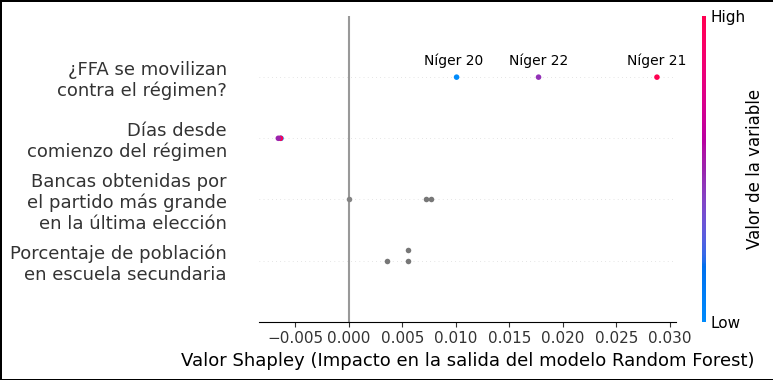

In [263]:
annot_rf_niger = [
    {'text': 'Níger 20', 'xy': (0.007, 3.2), 'xytext': (0.007, 3.2)},
    {'text': 'Níger 21', 'xy': (0.026, 3.2), 'xytext': (0.026, 3.2)},
    {'text': 'Níger 22', 'xy': (0.015, 3.2), 'xytext': (0.015, 3.2)},
]

f = shapley_violin_plot(rf,X_test.loc[(X_test['year']<2023)&(X_test['country_id']==get_key('Níger'))],annotations=annot_rf_niger,country=True);

plt.savefig('../entregas/imagenes/11_shapley_values_rf_niger.png',bbox_inches='tight',dpi=300)

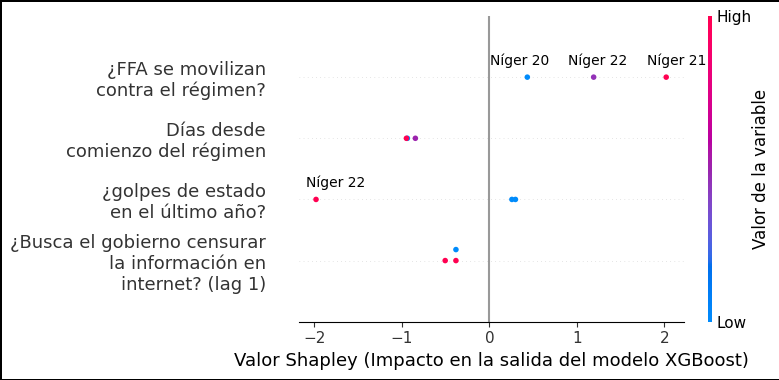

In [264]:
annot_xgb_niger = [
    {'text': 'Níger 20', 'xy': (0.41,  3.2), 'xytext'   : (0.007, 3.2)},
    {'text': 'Níger 21', 'xy': (1.8, 3.2),     'xytext' : (1.8, 3.2)},
    {'text': 'Níger 22', 'xy': (.9,  3.2),    'xytext'   : (.9,  3.2)},
    {'text': 'Níger 22', 'xy': (-2.1, 1.2),    'xytext'   : (-2.1,  1.2)},
    
]


f = shapley_violin_plot(xgb,X_test.loc[(X_test['year']<2023)&(X_test['country_id']==get_key('Níger'))],annotations=annot_xgb_niger,country=True);
plt.savefig('../entregas/imagenes/12_shapley_values_xgb_niger.png',bbox_inches='tight',dpi=300)

#### Afganistán

In [354]:
get_shap_outliers_country(rf,X_test,'v2regdur','Afganistán')

Días desde
comienzo del régimen


,país,año,v2regdur,shap,golpe,random forest
0,Afganistán,2020,5818.0,-0.012755,No,Verdadero negativo
1,Afganistán,2021,0.0,0.172800,No,Falso positivo
2,Afganistán,2022,139.0,-0.006834,No,Verdadero negativo


In [356]:
get_shap_outliers_country(rf,X_test,'v2x_hosinter','Afganistán')

¿El ejecutivo
no es más electo?


,país,año,v2x_hosinter,shap,golpe,random forest
0,Afganistán,2020,0.0,-0.002639,No,Verdadero negativo
1,Afganistán,2021,1.0,0.251989,No,Falso positivo
2,Afganistán,2022,0.0,-0.002577,No,Verdadero negativo


In [133]:
get_shap_outliers_country(rf,X_test,'v2xlg_leginter','Afganistán')

¿Legislatura
cerrada o abortada?


,país,año,v2xlg_leginter,shap,golpe,random forest
0,Afganistán,2020,0,-0.001661,No,Verdadero negativo
1,Afganistán,2021,1,0.061502,No,Falso positivo
2,Afganistán,2022,0,-0.001732,No,Verdadero negativo


In [147]:
get_shap_outliers_country(rf,X_test,'v2regendtype_lag_1','Afganistán')

Proceso más importante
para terminar con un
régimen (lag 1)


,país,año,v2regendtype_lag_1,shap,golpe,random forest
0,Afganistán,2020,1.0,0.005212,No,Verdadero negativo
1,Afganistán,2021,1.0,0.055126,No,Falso positivo
2,Afganistán,2022,13.0,-0.002763,No,Verdadero negativo


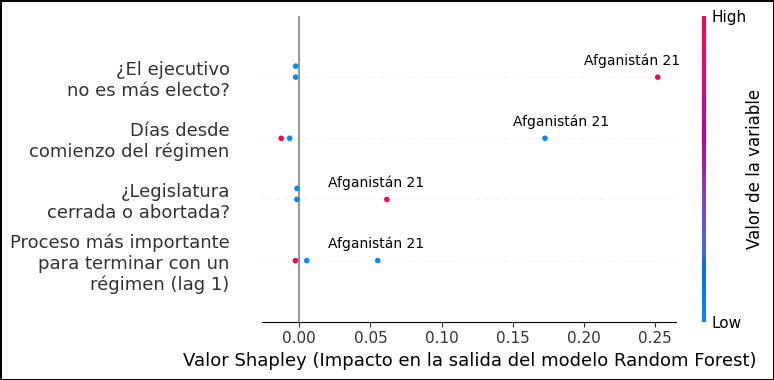

In [265]:
annot_rf_afg = [
    {'text': 'Afganistán 21', 'xy': (0.2, 3.2), 'xytext': (0.2, 3.2)},
    {'text': 'Afganistán 21', 'xy': (0.15, 3.2), 'xytext': (0.15, 2.2)},
    {'text': 'Afganistán 21', 'xy': (0.02, 1.2), 'xytext': (0.02, 1.2)},
    {'text': 'Afganistán 21', 'xy': (0.02, .2), 'xytext': (0.02, .2)},

]

f = shapley_violin_plot(rf,X_test[(X_test['year']<2023)&(X_test['country_id']==get_key('Afganistán'))],country=True,annotations=annot_rf_afg);
plt.savefig('../entregas/imagenes/13_shapley_values_rf_afganistan.png',bbox_inches='tight',dpi=300)

In [135]:
get_shap_outliers_country(xgb,X_test,'v2regdur','Afganistán')

Días desde
comienzo del régimen


,país,año,v2regdur,shap,golpe,xgboost
0,Afganistán,2020,5818.0,-0.899968,No,Verdadero negativo
1,Afganistán,2021,0.0,4.333076,No,Verdadero negativo
2,Afganistán,2022,139.0,0.693049,No,Verdadero negativo


In [139]:
get_shap_outliers_country(xgb,X_test,'v2regoppgroupsact_5','Afganistán')

¿FFA se movilizan
contra el régimen?


,país,año,v2regoppgroupsact_5,shap,golpe,xgboost
0,Afganistán,2020,0.143,-1.314598,No,Verdadero negativo
1,Afganistán,2021,0.000,-1.186528,No,Verdadero negativo
2,Afganistán,2022,0.000,-1.178007,No,Verdadero negativo


In [143]:
get_shap_outliers_country(xgb,X_test,'v2regendtype_lag_1','Afganistán')

Proceso más importante
para terminar con un
régimen (lag 1)


,país,año,v2regendtype_lag_1,shap,golpe,xgboost
0,Afganistán,2020,1.0,0.251622,No,Verdadero negativo
1,Afganistán,2021,1.0,1.235266,No,Verdadero negativo
2,Afganistán,2022,13.0,-0.221995,No,Verdadero negativo


In [148]:
get_shap_outliers_country(xgb,X_test,'v2x_hosinter','Afganistán')

¿El ejecutivo
no es más electo?


,país,año,v2x_hosinter,shap,golpe,xgboost
0,Afganistán,2020,0.0,-0.035260,No,Verdadero negativo
1,Afganistán,2021,1.0,1.458500,No,Verdadero negativo
2,Afganistán,2022,0.0,-0.025398,No,Verdadero negativo


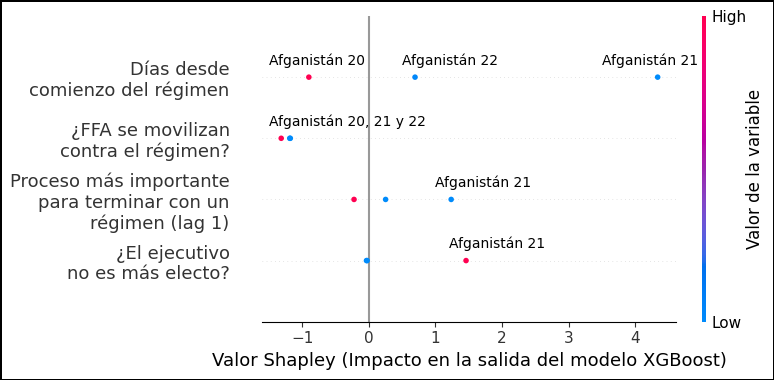

In [266]:
annot_rf_afg = [
    {'text': 'Afganistán 20', 'xy': (-1.5, 3.2), 'xytext' : (-1.5, 3.2)},
    {'text': 'Afganistán 21', 'xy': (3.5, 3.2), 'xytext': (3.5, 3.2)},
    {'text': 'Afganistán 22', 'xy': (0.5, 3.2), 'xytext': (0.5, 3.2)},
    {'text': 'Afganistán 20, 21 y 22', 'xy': (-1.5, 2.2), 'xytext': (-1.5, 2.2)},
    {'text': 'Afganistán 21', 'xy': (1, 1.2), 'xytext': (1, 1.2)},
    {'text': 'Afganistán 21', 'xy': (1.2, .2), 'xytext': (1.2, .2)},
    

]
f = shapley_violin_plot(xgb,X_test[(X_test['year']<2023)&(X_test['country_id']==get_key('Afganistán'))],country=True,annotations=annot_rf_afg);
plt.savefig('../entregas/imagenes/14_shapley_values_xgb_afganistan.png',bbox_inches='tight',dpi=300)

# Probalidad promedio por país

In [156]:
X_test

,country_id,year,codingstart_contemp,gapstart1,gapstart2,gapstart3,gapend1,gapend2,gapend3,v2x_polyarchy,...,v2edtehire_lag_10,v2edtefire_lag_10,coup_lag_10,region_1,region_2,region_3,region_4,region_5,region_6,region_7
70,3,2020,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.652,...,-0.251,-0.579,0.0,0,1,0,0,0,0,0
71,3,2021,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.613,...,-0.251,-0.579,0.0,0,1,0,0,0,0,0
72,3,2022,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.571,...,-0.251,-0.579,0.0,0,1,0,0,0,0,0
144,4,2020,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.754,...,NaN,NaN,0.0,0,1,0,0,0,0,0
145,4,2021,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.750,...,NaN,NaN,0.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12211,210,2021,1918,NaN,NaN,NaN,NaN,NaN,NaN,0.456,...,-1.151,-1.220,0.0,1,0,0,0,0,0,0
12212,210,2022,1918,NaN,NaN,NaN,NaN,NaN,NaN,0.449,...,-0.711,-1.220,0.0,1,0,0,0,0,0,0
12284,236,2020,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.262,...,-1.831,-1.961,0.0,0,0,0,1,0,0,0
12285,236,2021,1900,NaN,NaN,NaN,NaN,NaN,NaN,0.273,...,-1.831,-1.961,0.0,0,0,0,1,0,0,0


In [176]:
resultados_prob.dtypes

country_name     object
coup              int64
rf              float64
xgb             float32
dtype: object

In [197]:
resultados_prob = resultados.copy()
resultados_prob['coup'] = resultados['coup'].replace({'Sí':1,'No':0})
resultados_prob['rf']   = rf.predict_proba(X_test)[:,1]
resultados_prob['xgb']   = xgb.predict_proba(X_test)[:,1]
resultados_prob['country_name'] = resultados_prob['country_id'].astype(str).map(country_codes)
resultados_prob = resultados_prob.groupby('country_name',as_index=False).agg({'coup':'sum','rf':'mean','xgb':'mean'})
resultados_prob.loc[resultados_prob['coup']>=1,'golpe'] = 'Sí'
resultados_prob.loc[resultados_prob['coup']==0,'golpe'] = 'No'


C:\Users\joses\AppData\Local\Temp\ipykernel_19272\3411754224.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [202]:
resultados_prob.loc[resultados_prob['country_name']=='Gabón','golpe'] = 'Sí'

In [206]:
resultados_prob.melt(id_vars=['country_name','golpe','coup'])

,country_name,golpe,coup,variable,value
0,Afganistán,No,0,rf,1.949872e-01
1,Albania,No,0,rf,7.956386e-03
2,Alemania,No,0,rf,7.945654e-03
3,Angola,No,0,rf,1.411605e-02
4,Arabia Saudita,No,0,rf,8.063380e-03
...,...,...,...,...,...
353,Yemen,No,0,xgb,1.029537e-05
354,Yibuti,No,0,xgb,2.392842e-05
355,Zambia,No,0,xgb,1.315219e-06
356,Zanzíbar,No,0,xgb,9.367727e-08


In [187]:
from plotnine import facet_wrap, gri

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/16_prob_rf_comp.png


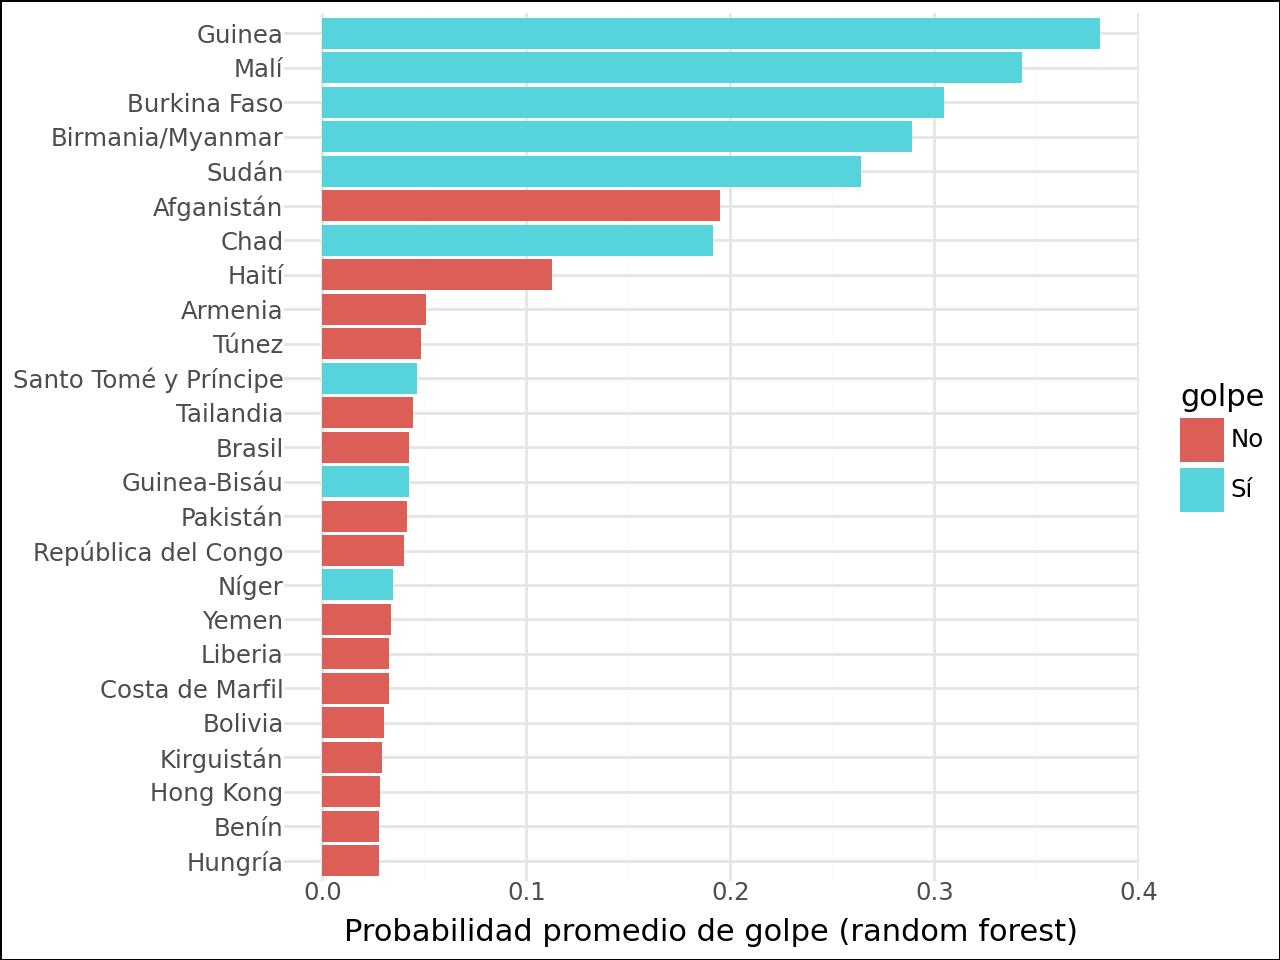

In [215]:
f = ggplot(resultados_prob.sort_values('rf',ascending=False).head(25))+\
    aes(x='reorder(country_name,rf)',y='rf',fill='golpe')+\
    labs(y='Probabilidad promedio de golpe (random forest)',x='')+\
    geom_bar(stat='identity')+coord_flip()+\
    theme_minimal()+\
    theme(plot_background=element_rect(color='black'),
        plot_caption=element_text(size=7,alpha=.7))
ggsave(f,'../entregas/imagenes/16_prob_rf_comp.png',width=5,height=3)
f

In [216]:
f = ggplot(resultados_prob.sort_values('xgb',ascending=False).head(25))+\
    aes(x='reorder(country_name,xgb)',y='xgb',fill='golpe')+\
    labs(y='Probabilidad promedio de golpe (XGBoost)',x='')+\
    geom_bar(stat='identity')+coord_flip()+\
    theme_minimal()+\
    theme(plot_background=element_rect(color='black'),
        plot_caption=element_text(size=7,alpha=.7))
ggsave(f,'../entregas/imagenes/17_prob_xgb_comp.png',width=5,height=3)

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../entregas/imagenes/17_prob_xgb_comp.png


In [223]:
with open('../optimizacion_bayesiana/trials/trials_RF.pkl','rb') as f:
    trials_rf = pickle.load(f)

In [230]:
pd.DataFrame(trials_rf.trials)

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': -0.7063857677902622, 'status': 'ok'}","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-06-18 00:09:59.880,2024-06-18 01:02:43.047
1,2,1,None,"{'loss': -0.6397191011235955, 'status': 'ok'}","{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-06-18 01:02:43.833,2024-06-18 01:28:20.832
2,2,2,None,"{'loss': -0.5666666666666667, 'status': 'ok'}","{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-06-18 01:28:21.640,2024-06-18 01:31:57.875
3,2,3,None,"{'loss': -0.6397191011235955, 'status': 'ok'}","{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-06-18 01:31:58.677,2024-06-18 01:44:36.302
4,2,4,None,"{'loss': -0.64, 'status': 'ok'}","{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2024-06-18 01:44:37.188,2024-06-18 01:52:00.771
...,...,...,...,...,...,...,...,...,...,...
95,2,95,None,"{'loss': -0.6394350102145047, 'status': 'ok'}","{'tid': 95, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2024-06-22 19:53:21.216,2024-06-22 20:22:18.251
96,2,96,None,"{'loss': -0.7230524344569289, 'status': 'ok'}","{'tid': 96, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2024-06-22 20:22:19.128,2024-06-22 21:21:03.724
97,2,97,None,"{'loss': -0.7230524344569289, 'status': 'ok'}","{'tid': 97, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2024-06-22 21:21:04.570,2024-06-22 22:16:43.021
98,2,98,None,"{'loss': -0.7063857677902622, 'status': 'ok'}","{'tid': 98, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2024-06-22 22:16:44.043,2024-06-22 23:06:12.569
